In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from statsmodels.tsa.seasonal import STL
from prophet import Prophet

# Load Excel file
df = pd.read_excel("GenerationData.xlsx")

# Rename columns for clarity
df.columns = ['Date', 'Type'] + [f'Time_{i}' for i in range(1, len(df.columns) - 1)]

# Filter only Scheduled Generation rows
df = df[df['Type'] == 'Scheduled Generation (MW)'].drop(columns=['Type'])

print("Step 1: Loaded and filtered data.")
print(df.head())


Step 1: Loaded and filtered data.
        Date  Time_1  Time_2  Time_3  Time_4  Time_5  Time_6  Time_7  Time_8  \
0 2020-07-28   683.0   683.0   683.0   683.0   683.0   683.0   683.0   683.0   
1 2020-07-29   683.0   683.0   683.0   683.0   683.0   683.0   683.0   683.0   
2 2020-07-30   683.0   683.0   683.0   683.0   683.0   683.0   683.0   683.0   
3 2020-07-31   683.0   683.0   683.0   683.0   683.0   683.0   683.0   683.0   
4 2020-08-01   683.0   683.0   683.0   683.0   683.0   683.0   683.0   683.0   

   Time_9  ...  Time_87  Time_88  Time_89  Time_90  Time_91  Time_92  Time_93  \
0   683.0  ...    683.0    683.0    683.0    683.0    683.0    683.0    683.0   
1   683.0  ...    683.0    683.0    683.0    683.0    683.0    683.0    683.0   
2   683.0  ...    683.0    683.0    683.0    683.0    683.0    683.0    683.0   
3   683.0  ...    683.0    683.0    683.0    683.0    683.0    683.0    683.0   
4   683.0  ...    683.0    683.0    683.0    683.0    683.0    683.0    683.0   

In [2]:
# Melt wide format to long format
df_melted = df.melt(id_vars=['Date'], var_name='TimeBlock', value_name='Generation')

# Create 96 time intervals (00:00 to 23:45 at 15-minute steps)
time_blocks = pd.date_range(start="00:00", periods=96, freq="15min").time
time_block_mapping = dict(zip([f'Time_{i}' for i in range(1, 97)], time_blocks))

# Apply mapping and create datetime
df_melted['Time'] = df_melted['TimeBlock'].map(time_block_mapping)
df_melted['Datetime'] = pd.to_datetime(df_melted['Date'].astype(str)) + pd.to_timedelta(df_melted['Time'].astype(str))

# Final time series DataFrame
df_timeseries = df_melted[['Datetime', 'Generation']].sort_values('Datetime').reset_index(drop=True)

print("Step 2: Reshaped to time series.")
print(df_timeseries.head())


Step 2: Reshaped to time series.
             Datetime  Generation
0 2020-07-28 00:00:00       683.0
1 2020-07-28 00:15:00       683.0
2 2020-07-28 00:30:00       683.0
3 2020-07-28 00:45:00       683.0
4 2020-07-28 01:00:00       683.0


In [3]:
# Convert to daily average generation
daily_df = df_timeseries.resample('D', on='Datetime').mean().reset_index()

print("Step 3: Resampled to daily average.")
print(daily_df.head())
# Convert to daily average generation
daily_df = df_timeseries.resample('D', on='Datetime').mean().reset_index()

print("Step 3: Resampled to daily average.")
print(daily_df.head())


Step 3: Resampled to daily average.
    Datetime  Generation
0 2020-07-28  681.385417
1 2020-07-29  691.250000
2 2020-07-30  691.250000
3 2020-07-31  691.250000
4 2020-08-01  682.760417
Step 3: Resampled to daily average.
    Datetime  Generation
0 2020-07-28  681.385417
1 2020-07-29  691.250000
2 2020-07-30  691.250000
3 2020-07-31  691.250000
4 2020-08-01  682.760417


Step 4: STL decomposition successful. Showing plot...


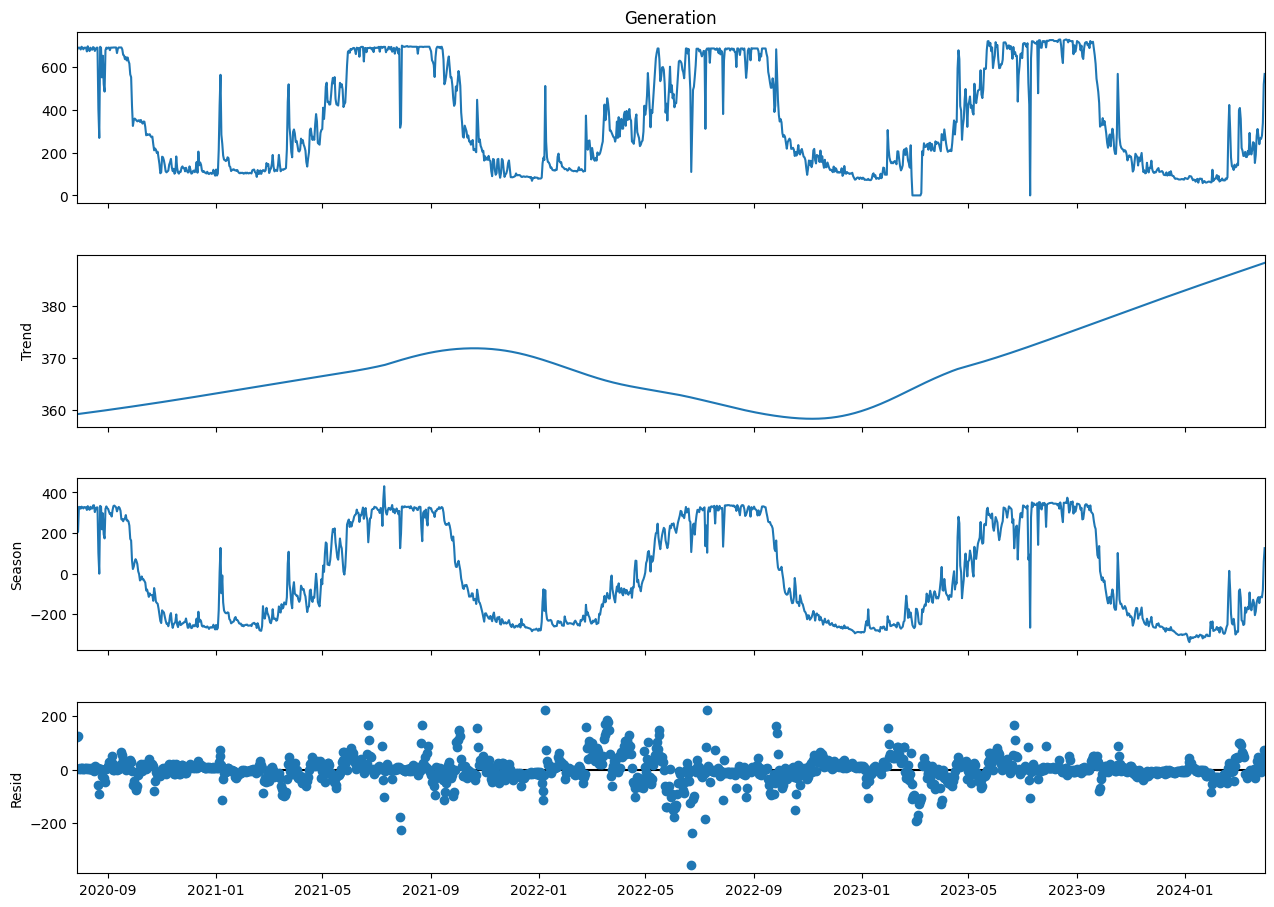

In [4]:
# Apply STL decomposition to see trend and seasonality
stl = STL(daily_df.set_index('Datetime')['Generation'], period=365)
result = stl.fit()

print("Step 4: STL decomposition successful. Showing plot...")

fig = result.plot()
fig.set_size_inches(14, 10)
plt.show()


In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

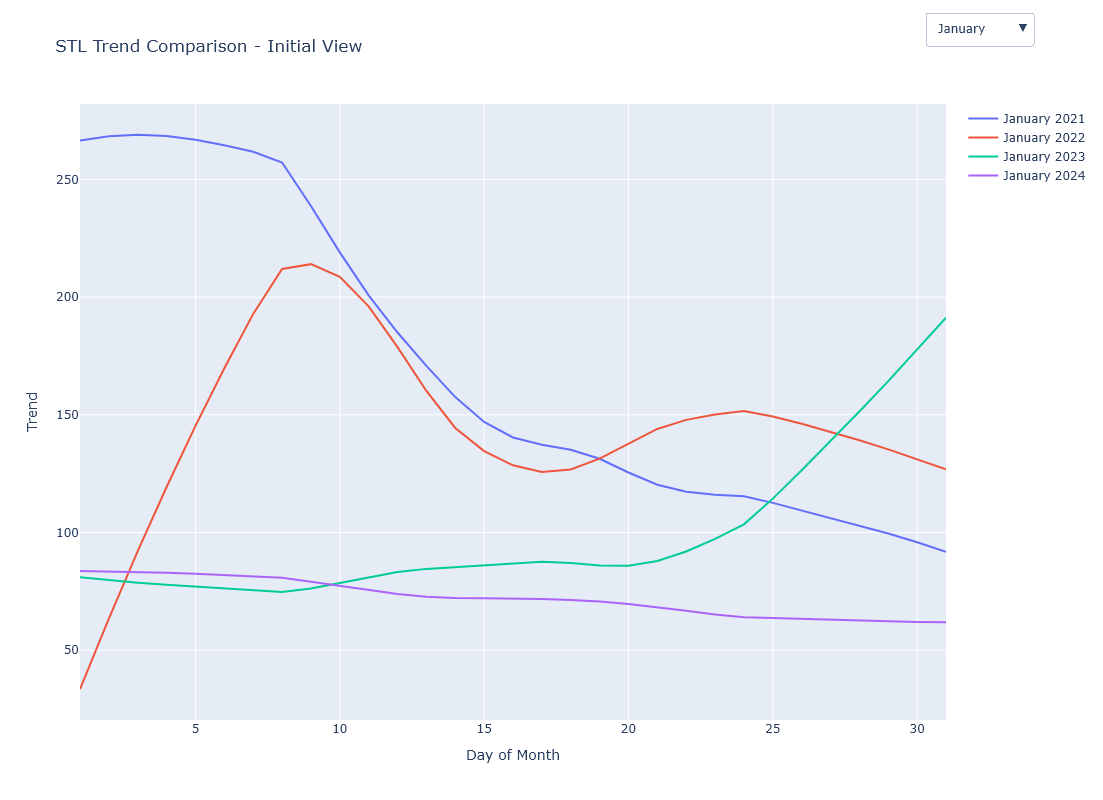

In [10]:
import pandas as pd
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import STL

# Step 1: Extract components
daily_df['Year'] = daily_df['Datetime'].dt.year.astype(str)
daily_df['Month'] = daily_df['Datetime'].dt.strftime('%B')  # Full month name
daily_df['Day'] = daily_df['Datetime'].dt.day

months = daily_df['Month'].unique()
fig_plotly = go.Figure()
trace_labels = []

# Step 2: Add trend lines grouped by Month (overlaying different years)
for month in sorted(daily_df['Month'].unique(), key=lambda m: pd.to_datetime(m, format='%B').month):
    for year in sorted(daily_df['Year'].unique()):
        month_df = daily_df[(daily_df['Month'] == month) & (daily_df['Year'] == year)]
        if len(month_df) < 14:
            continue

        ts = month_df.set_index('Datetime')['Generation']
        stl = STL(ts, period=7)
        res = stl.fit()

        # Use Day-of-month for x-axis to align across years
        x = month_df['Day'].values
        fig_plotly.add_trace(go.Scatter(
            x=x, y=res.trend,
            mode='lines',
            name=f"{month} {year}",
        ))
        trace_labels.append(month)

# Step 3: Create dropdown for each month to overlay across years
month_buttons = []
for month in sorted(set(trace_labels), key=lambda m: pd.to_datetime(m, format='%B').month):
    visibility = [label == month for label in trace_labels]
    month_buttons.append(dict(
        label=month,
        method='update',
        args=[{'visible': visibility},
              {'title': f"STL Trend Comparison - {month} Across Years",
               'xaxis': {'title': 'Day of Month'}}]
    ))

# Step 4: Layout with dropdown
fig_plotly.update_layout(
    height=800,
    width=1000,
    title_text="STL Trend Comparison - Initial View",
    xaxis_title="Day of Month",
    yaxis_title="Trend",
    updatemenus=[dict(
        active=0,
        buttons=month_buttons,
        direction="down",
        x=1.1,
        y=1.15,
        xanchor="right",
        yanchor="top"
    )]
)

# Step 5: Initial visibility (first month traces only)
first_month = sorted(set(trace_labels), key=lambda m: pd.to_datetime(m, format='%B').month)[0]
for i, label in enumerate(trace_labels):
    fig_plotly.data[i].visible = (label == first_month)

fig_plotly.show()


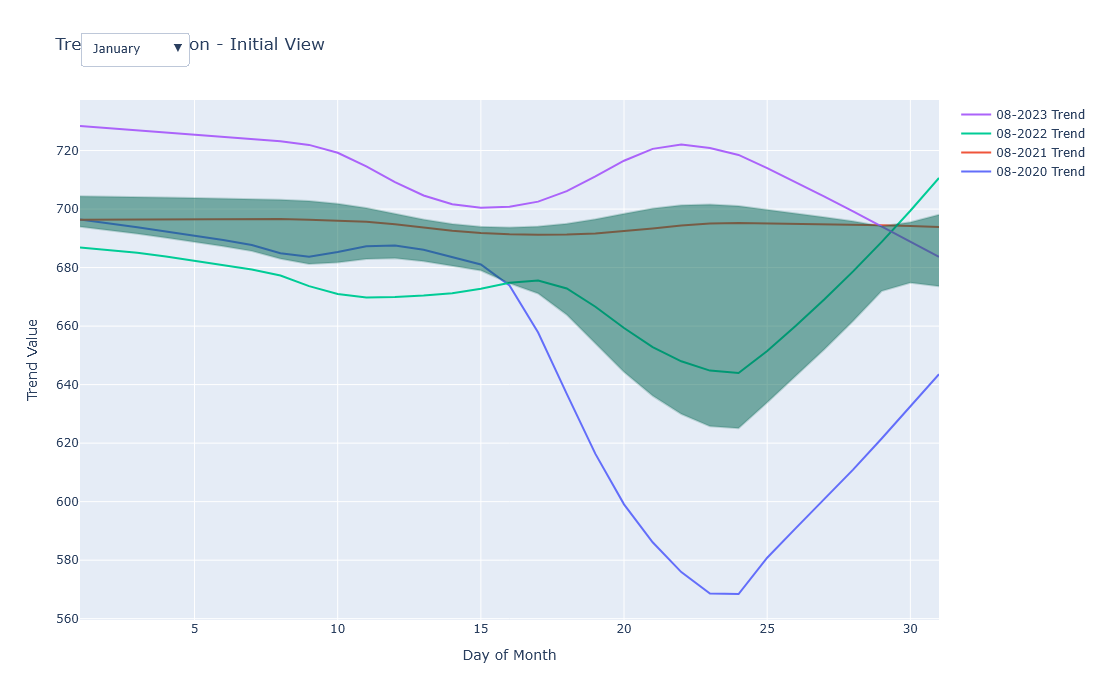

In [6]:
import pandas as pd
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import STL
import numpy as np

# Step 1: Prepare data
daily_df['Month'] = daily_df['Datetime'].dt.strftime('%m')  # '01', '02', ...
daily_df['Year'] = daily_df['Datetime'].dt.strftime('%Y')
daily_df['MonthYear'] = daily_df['Datetime'].dt.strftime('%Y-%m')

fig_plotly = go.Figure()
trace_labels = []  # (Month, Year)
trend_store = {}   # Store trends per month for IQR calculation

# Step 2: Add trend traces with normalized day index
for my in sorted(daily_df['MonthYear'].unique()):
    year = my[:4]
    month = my[5:]

    month_df = daily_df[daily_df['MonthYear'] == my]
    if len(month_df) < 14:
        continue

    ts = month_df.set_index('Datetime')['Generation']
    stl = STL(ts, period=7)
    res = stl.fit()

    trend_values = res.trend.values
    day_nums = list(range(1, len(trend_values) + 1))

    # Store trend values for IQR
    trend_store.setdefault(month, []).append(trend_values)

    fig_plotly.add_trace(go.Scatter(
        x=day_nums,
        y=trend_values,
        mode='lines',
        name=f"{month}-{year} Trend"
    ))
    trace_labels.append((month, year))

# Step 3: Month Dropdown with IQR overlay
months = sorted(set([label[0] for label in trace_labels]))
month_buttons = []

# Compute IQR lines
iqr_traces = {}
for m in months:
    trends = trend_store[m]
    # Pad all arrays to same length (short months will be NaN-padded)
    max_len = max(len(t) for t in trends)
    padded = np.array([np.pad(t, (0, max_len - len(t)), constant_values=np.nan) for t in trends])
    q1 = np.nanpercentile(padded, 25, axis=0)
    q3 = np.nanpercentile(padded, 75, axis=0)
    x_vals = list(range(1, max_len + 1))

    # Add IQR band as shaded area
    lower = go.Scatter(x=x_vals, y=q1, fill=None, mode='lines',
                       line=dict(color='rgba(0,100,80,0.2)'), name=f"{m} Q1", showlegend=False)
    upper = go.Scatter(x=x_vals, y=q3, fill='tonexty', mode='lines',
                       line=dict(color='rgba(0,100,80,0.2)'), name=f"{m} Q3", showlegend=False)
    
    fig_plotly.add_trace(lower)
    fig_plotly.add_trace(upper)
    trace_labels.append((m, 'iqr_lower'))
    trace_labels.append((m, 'iqr_upper'))

# Buttons
for m in months:
    visibility = [(label[0] == m and 'iqr' not in label[1]) or label[0] == m for label in trace_labels]
    month_name = pd.to_datetime(f'2024-{m}-01').strftime('%B')
    month_buttons.append(dict(
        label=month_name,
        method='update',
        args=[{'visible': visibility},
              {'title': f"Trend Comparison - {month_name} (Across Years) with IQR"}]
    ))

# Step 4: Layout
fig_plotly.update_layout(
    height=700,
    width=1000,
    title="Trend Comparison - Initial View",
    xaxis_title="Day of Month",
    yaxis_title="Trend Value",
    updatemenus=[
        dict(
            buttons=month_buttons,
            direction="down",
            showactive=True,
            x=0.0,
            xanchor="left",
            y=1.15,
            yanchor="top",
            pad={"r": 10, "t": 10}
        )
    ]
)

# Step 5: Initial visibility (first month)
initial_month = trace_labels[0][0]
for i, label in enumerate(trace_labels):
    fig_plotly.data[i].visible = (label[0] == initial_month)

fig_plotly.show()


In [11]:
from prophet import Prophet
from scipy.stats import iqr
from datetime import timedelta
import pandas as pd

# Step 1: Prepare Data
prophet_df = daily_df[['Datetime', 'Generation']].rename(columns={'Datetime': 'ds', 'Generation': 'y'}).dropna()

# Step 2: Fit Prophet
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(prophet_df)

# Step 3: Forecast ahead (~600 days)
future = model.make_future_dataframe(periods=600)
forecast = model.predict(future)

# Step 4: Clean forecast
forecast_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'Datetime', 'yhat': 'Forecast'})

# Step 5: Maintenance duration input
maintenance_days = int(input("🔧 Enter number of days for maintenance window: "))

# Step 6: Get desired month(s) from user
month_input = input("📅 Enter month number(s) or range (e.g., '12' or '11-2'): ").strip()

def parse_month_input(month_str):
    if '-' in month_str:
        start, end = map(int, month_str.split('-'))
        # Handle wrap-around (e.g., 11-2)
        if start <= end:
            return list(range(start, end + 1))
        else:
            return list(range(start, 13)) + list(range(1, end + 1))
    else:
        return [int(month_str)]

target_months = parse_month_input(month_input)

# Step 7: Remove outliers using IQR
q1 = forecast_df['Forecast'].quantile(0.25)
q3 = forecast_df['Forecast'].quantile(0.75)
lower = q1 - 1.5 * iqr(forecast_df['Forecast'])
upper = q3 + 1.5 * iqr(forecast_df['Forecast'])

clean_forecast = forecast_df[
    (forecast_df['Forecast'] >= lower) &
    (forecast_df['Forecast'] <= upper)
].copy()

# Step 8: Filter forecast to dates in user-defined months
cutoff_date = pd.to_datetime("2024-04-01")  # Could also use pd.Timestamp.today()
clean_forecast = clean_forecast[
    (clean_forecast['Datetime'] >= cutoff_date) &
    (clean_forecast['Datetime'].dt.month.isin(target_months))
]

# Step 9: Calculate rolling loss
clean_forecast['RollingLoss'] = clean_forecast['Forecast'].rolling(window=maintenance_days).sum()

# Step 10: Top 3 windows
best_windows = clean_forecast.dropna().nsmallest(3, 'RollingLoss')

# Step 11: Output
print(f"\n🔧 Top {len(best_windows)} Maintenance Windows after {cutoff_date.date()} in selected months {target_months} for {maintenance_days} Days:\n")
for i, row in best_windows.iterrows():
    end_date = row['Datetime']
    start_date = end_date - timedelta(days=maintenance_days - 1)
    avg_loss = round(row['RollingLoss'] / maintenance_days, 2)
    total_loss = round(row['RollingLoss'], 2)
    print(f"🗓️ {start_date.date()} to {end_date.date()} → Avg Loss: {avg_loss} MW/day | Total: {total_loss} MW")


11:57:41 - cmdstanpy - INFO - Chain [1] start processing
11:57:42 - cmdstanpy - INFO - Chain [1] done processing


🔧 Enter number of days for maintenance window:  5
📅 Enter month number(s) or range (e.g., '12' or '11-2'):  10-3



🔧 Top 3 Maintenance Windows after 2024-04-01 in selected months [10, 11, 12, 1, 2, 3] for 5 Days:

🗓️ 2024-12-16 to 2024-12-20 → Avg Loss: 90.35 MW/day | Total: 451.77 MW
🗓️ 2024-12-17 to 2024-12-21 → Avg Loss: 91.2 MW/day | Total: 455.98 MW
🗓️ 2024-12-18 to 2024-12-22 → Avg Loss: 91.66 MW/day | Total: 458.28 MW
